<a href="https://colab.research.google.com/github/avidnerd/Breathwise/blob/main/PennappsXXV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Code


In [1]:
!pip install tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models

patient_info = pd.read_csv(r"/content/drive/MyDrive/subhi/PennApps_XXV/resp_db/Resp_DB_Kaggle/demographic_info.txt",names=['Patient ID','Age','Sex','Adult BMI','Child Weight(kgs)','Child height(cms)'],delimiter=" ")

diagnoses = pd.read_csv(r"/content/drive/MyDrive/subhi/PennApps_XXV/resp_db/Resp_DB_Kaggle/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",names=['Patient ID','Diagnosis'])

patient_record = patient_info.join(diagnoses.set_index('Patient ID'),on='Patient ID',how='left')

root = r"/content/drive/MyDrive/subhi/PennApps_XXV/resp_db/Resp_DB_Kaggle/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files"
files = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in files:
    tokens = s.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, s + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    i = recording_info
    a = recording_annotations
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a


In [4]:
filenames = pd.DataFrame(data = {'filename':files})
audio = r"/content/drive/MyDrive/subhi/PennApps_XXV/resp_db/Resp_DB_Kaggle/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files"
dign = []
num = []

sample_rate = []
duration = []
for i in range(len(filenames['filename'])):
  info = filenames['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  dign.append(patient_record['Diagnosis'][int(patient_id) - 101])
  num.append(patient_id)

filenames['Diagnosis'] = dign
filenames['Patient Number'] = num

print(filenames.head())
print(len(filenames))
print(filenames['Diagnosis'].unique())

                 filename  Diagnosis Patient Number
0  134_2b3_Ar_mc_LittC2SE       COPD            134
1  135_2b2_Pl_mc_LittC2SE  Pneumonia            135
2  135_2b1_Pl_mc_LittC2SE  Pneumonia            135
3  135_2b3_Ar_mc_LittC2SE  Pneumonia            135
4  135_2b3_Pr_mc_LittC2SE  Pneumonia            135
707
['COPD' 'Pneumonia' 'URTI' 'Healthy' 'Bronchiolitis' 'Bronchiectasis'
 'Asthma' 'LRTI']


In [5]:
def preprocess(file_path,mode='mfcc'):
    sr_new = 16000
    x, sr = librosa.load(audio_file, sr=sr_new)
    max_len = 5 * sr_new
    if x.shape[0] < max_len:
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      x = x[:max_len]

    return librosa.feature.mfcc(y=x, sr=sr_new)


In [6]:
labels = []
preprocessed_data = []
for i in range(len(filenames['filename'])):
  audio_file = audio +"/"+ filenames['filename'][i] + '.wav'
  if os.path.exists(audio_file):
    data = preprocess(audio_file,mode='mfcc')
    labels.append(filenames['Diagnosis'][i])
    preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
print(labels)
labels = np.array(labels)

['COPD', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'URTI', 'URTI', 'Pneumonia', 'Pneumonia', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'Pneumonia', 'COPD', 'COPD', 'COPD', 'Pneumonia', 'Pneumonia', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'Pneumonia', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'Healthy', 'COPD', 'Healthy', 'Healthy', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'Bronchiolitis', 'URTI', 'COPD', 'COPD', 'Bronchiolitis', 'URTI', 'Bronchiolitis', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COP

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
print(preprocessed_data.shape)

(706, 20, 157)


Counter({'COPD': 616, 'Pneumonia': 29, 'Healthy': 24, 'URTI': 19, 'Bronchiolitis': 8, 'Bronchiectasis': 7, 'LRTI': 2, 'Asthma': 1})


<Axes: >

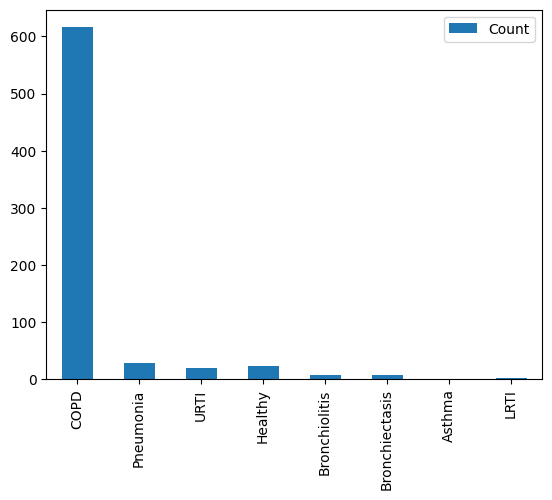

In [8]:
import pandas as pd
from collections import Counter

label_counts = Counter(labels)
print(label_counts)

label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
label_df.plot(kind='bar')

In [9]:
import pandas as pd
from collections import Counter
import numpy as np

diagnosis_mapping = {
    'COPD': 0,
    'Healthy': 1,
    'URTI': 2,
    'Bronchiectasis': 3,
    'Pneumonia': 4,
    'Bronchiolitis': 5,
    'Asthma': 7,
    'LRTI': 6
}

numerical_labels = pd.Series(labels).map(diagnosis_mapping).values

indices_to_keep = numerical_labels != 7

numerical_labels = numerical_labels[indices_to_keep]

preprocessed_data = preprocessed_data[indices_to_keep]



In [10]:
unique_values, counts = np.unique(numerical_labels, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 616
Value: 1, Count: 24
Value: 2, Count: 19
Value: 3, Count: 7
Value: 4, Count: 29
Value: 5, Count: 8
Value: 6, Count: 2


In [11]:
print(preprocessed_data.shape)
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))
print(preprocessed_data.shape)

(705, 20, 157)
(705, 20, 157, 1)


In [12]:
from imblearn.over_sampling import ADASYN
import numpy as np


print("Shape of preprocessed_data:", preprocessed_data.shape)
print("Shape of numerical_labels:", numerical_labels.shape)


n_samples, height, width, channels = preprocessed_data.shape
X_reshaped = preprocessed_data.reshape(n_samples, -1)

adasyn = ADASYN(sampling_strategy='minority', n_neighbors=1)
labs = numerical_labels[:]

X_resampled, y_resampled = adasyn.fit_resample(X_reshaped, labs)
X_restored = X_resampled.reshape(-1, 20, 157, 1)

unique_values, counts = np.unique(y_resampled, return_counts=True)

print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

unique_values, counts = np.unique(y_resampled, return_counts=True)

print("\nAfter resampling:")
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")



Shape of preprocessed_data: (705, 20, 157, 1)
Shape of numerical_labels: (705,)
Shape of X_resampled: (1319, 3140)
Shape of y_resampled: (1319,)

After resampling:
Value: 0, Count: 616
Value: 1, Count: 24
Value: 2, Count: 19
Value: 3, Count: 7
Value: 4, Count: 29
Value: 5, Count: 8
Value: 6, Count: 616


Shape of preprocessed_data: (705, 20, 157, 1)
Shape of numerical_labels: (705,)


ValueError: Found input variables with inconsistent numbers of samples: [705, 1319]

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X_restored, y_resampled, stratify=y_resampled,
                                                    test_size=0.2, random_state = 42)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_rows = 20
num_columns = 157
num_channels = 1

num_labels = len(numerical_labels)
filter_size = 2

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns,num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(7, activation='softmax'))

model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 19, 156, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9, 78, 64)           │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 77, 32)           │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4, 38, 64)           │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 37, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,407 (110.96 KB)

 Trainable params: 28,407 (110.96 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

num_epochs = 30
num_batch_size = 64
callbacks = [
    ModelCheckpoint(
        filepath='mymodel3_{epoch:02d}.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
num_labels = 7

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)

print("Training completed in time: ", duration)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.4621 - loss: 2.7657
Epoch 1: val_accuracy improved from -inf to 0.82075, saving model to mymodel3_01.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 574ms/step - accuracy: 0.4682 - loss: 2.6997 - val_accuracy: 0.8208 - val_loss: 0.7238
Epoch 2/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8750 - loss: 0.5404
Epoch 2: val_accuracy improved from 0.82075 to 0.83962, saving model to mymodel3_02.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8197 - loss: 0.7331 - val_accuracy: 0.8396 - val_loss: 0.6079
Epoch 3/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9062 - loss: 0.4742
Epoch 3: val_accuracy improved from 0.83962 to 0.86792, saving model to mymodel3_03.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8712 - loss: 0.5553 - val_accuracy: 0.8679 - val_loss: 0.5774
Epoch 4/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8438 - loss: 0.5426
Epoch 4: val_accuracy did not improve from 0

In [19]:

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save("model.h5")

print("Model architecture saved to model.json")
print("Model weights saved to model_weights.h5")


Model architecture saved to model.json
Model weights saved to model_weights.h5


In [27]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "sample_data/tfjs_mod")

failed to lookup keras version from the file,
    this is likely a weight only file


In [25]:
!pip install tensorflowjs

!tensorflowjs_converter --input_format keras 'model.h5' 'tfjs_model/'

2024-09-22 01:14:28.296931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 01:14:28.317415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 01:14:28.323647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 01:14:29.377376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


Model loaded successfully.


# Unused Code / First Attempt

In [61]:
main_dir = '/content/drive/MyDrive/subhi/PennApps_XXV/resp_db/dataset_1sec'
label_folders = ['covid', 'healthy', 'lower', 'upper', 'obstructive']

In [62]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from os import walk
import os

def segment_coughs_mel_spec(audio_path, sr=48000, frame_size=2048, hop_length=512, rms_threshold=0.09, n_mels=128):
    audio, _ = librosa.load(audio_path, sr=sr, duration=1.0)

    rms = librosa.feature.rms(y=audio, frame_length=frame_size, hop_length=hop_length)[0]

    rms = rms / np.max(rms)

    segments = []
    current_segment = []
    in_segment = False
    min_length_frames = int(0.2 * sr / hop_length)
    max_length_frames = int(1.0 * sr / hop_length)
    buffer_frames = int(0.03 * sr / hop_length)

    for i, rms_value in enumerate(rms):
        if rms_value > rms_threshold:
            if not in_segment:
                in_segment = True
                start_frame = max(0, i - buffer_frames)
            current_segment.append(i)
        else:
            if in_segment:
                in_segment = False
                end_frame = min(len(rms), i + buffer_frames)
                if len(current_segment) >= min_length_frames and len(current_segment) <= max_length_frames:
                    segments.append((start_frame, end_frame))
                current_segment = []
    if in_segment and len(current_segment) >= min_length_frames and len(current_segment) <= max_length_frames:
        end_frame = min(len(rms), i + buffer_frames)
        segments.append((start_frame, end_frame))


    segs = []

    for start_frame, end_frame in segments:
        start_sample = start_frame * hop_length
        end_sample = end_frame * hop_length
        cough_segment = audio[start_sample:end_sample]

        mel_spectrogram = librosa.feature.melspectrogram(y=cough_segment, sr=sr, n_fft=frame_size, hop_length=hop_length, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        segs.append(mel_spectrogram_db)
    return segs


cough_data = {}
for label in label_folders:
  cough_data[label] = []
  folder_path = os.path.join(main_dir, label)
  for filename in os.listdir(folder_path):
    if filename.endswith(".wav"):
      file_path = os.path.join(folder_path, filename)
      seggs = segment_coughs_mel_spec(file_path)
      print(len(seggs))
      for seg in seggs:
        cough_data[label].append(seg)



2
1
1
2
2
2
1
1
1
1
1
2
2
2
2
0
3
1
2
1
2
2
0
1
2
2
2
1
0
1
1
1
1
2
2
1
1
2
1
2
2
1
3
3
2
1
1
2
1
2
3
1
1
2
0
1
1
2
2
1
2
1
2
2
1
2
1
1
0
2
2
2
3
1
2
2
1
2
2
1
2
1
2
1
1
2
2
2
2
1
1
1
1
1
2
1
2
1
1
2
2
2
1
1
1
1
2
2
2
2
1
2
1
2
2
2
1
1
0
2
2
2
1
1
2
1
2
1
2
1
1
1
2
2
1
2
1
2
1
1
1
1
1
1
2
2
2
2
2
1
2
2
2
2
1
1
2
1
2
2
2
1
3
1
2
0
0
1
1
3
2
2
1
2
1
1
2
1
2
2
1
2
2
1
2
2
2
1
1
2
1
1
2
2
2
3
1
1
2
2
2
2
2
3
1
1
1
1
2
2
1
1
2
1
1
2
1
2
2
2
1
2
2
2
2
2
2
3
2
1
2
1
2
2
1
1
2
1
2
1
1
2
1
2
2
1
1
1
2
2
2
1
2
2
2
2
2
1
1
1
1
2
1
1
3
2
0
2
2
2
2
2
2
2
2
1
1
1
2
0
1
1
1
2
1
1
2
1
2
1
1
2
2
2
2
2
2
0
1
2
2
2
1
2
1
1
2
2
3
2
1
3
2
1
1
1
1
2
1
1
2
1
3
1
1
3
2
1
1
1
1
0
1
2
1
2
1
1
2
2
3
1
3
2
1
1
1
1
0
1
1
1
2
1
1
2
1
2
1
1
2
2
1
1
2
2
2
2
1
1
2
1
2
1
2
3
1
1
1
2
2
2
0
2
1
3
1
2
2
2
2
2
2
1
2
1
2
2
1
1
2
1
2
2
2
1
1
1
2
2
1
1
1
0
2
1
2
1
0
2
0
2
1
1
2
1
2
1
0
3
2
2
1
2
1
2
1
1
1
1
1
2
1
1
2
1
1
2
1
1
1
1
3
1
1
1
1
1
0
1
1
2
1
1
2
1
2
3
2
2
1
1
2
1
2
1
2
2
1
0
1
2
1
2
1
2
2
3
1
2
0
2
1
1
0
1
1
1
1
2


In [63]:
print(cough_data.keys())

dict_keys(['covid', 'healthy', 'lower', 'upper', 'obstructive'])


In [64]:
print(len(cough_data['healthy']))
print(len(cough_data['covid']))
print(len(cough_data['lower']))
print(len(cough_data['upper']))
print(len(cough_data['obstructive']))

817
1010
1469
921
266


In [65]:
print(cough_data['healthy'][0])

[[-45.959995 -44.69272  -46.826576 ... -80.       -80.       -80.      ]
 [-48.458435 -40.38865  -41.458942 ... -80.       -80.       -80.      ]
 [-44.06295  -36.62664  -34.88357  ... -80.       -80.       -80.      ]
 ...
 [-77.725266 -80.       -80.       ... -80.       -80.       -80.      ]
 [-77.77947  -80.       -80.       ... -80.       -80.       -80.      ]
 [-77.813225 -80.       -80.       ... -80.       -80.       -80.      ]]


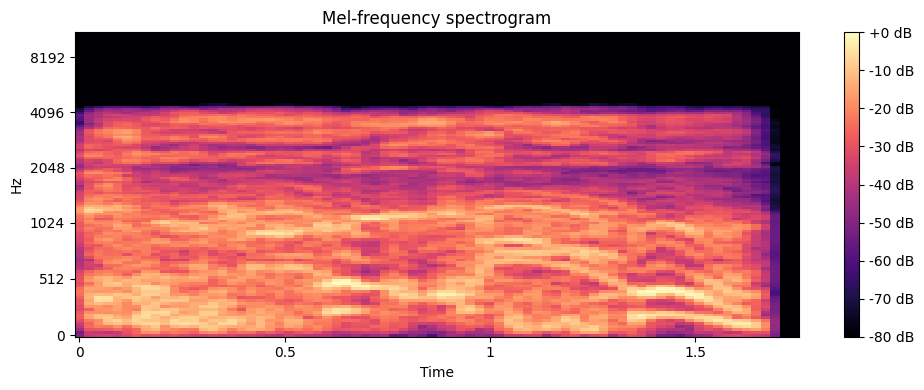

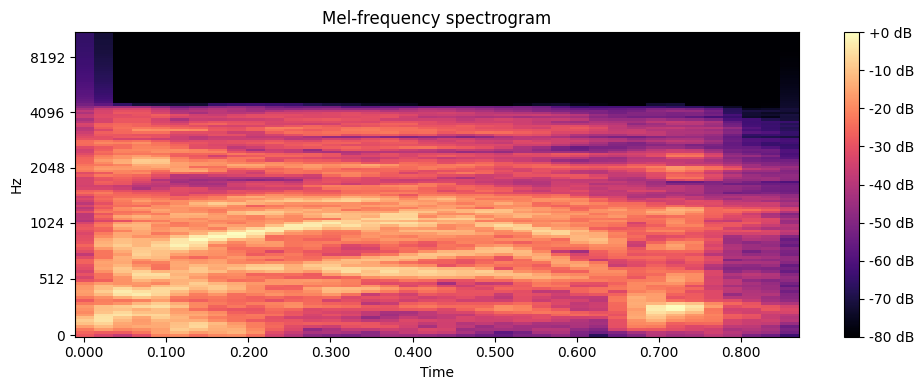

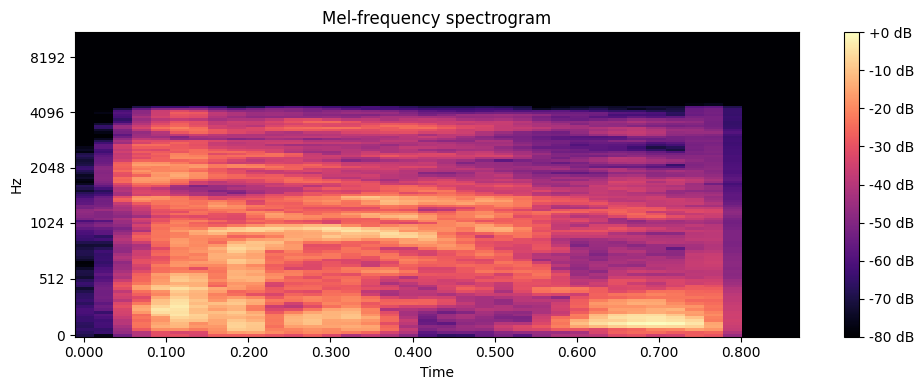

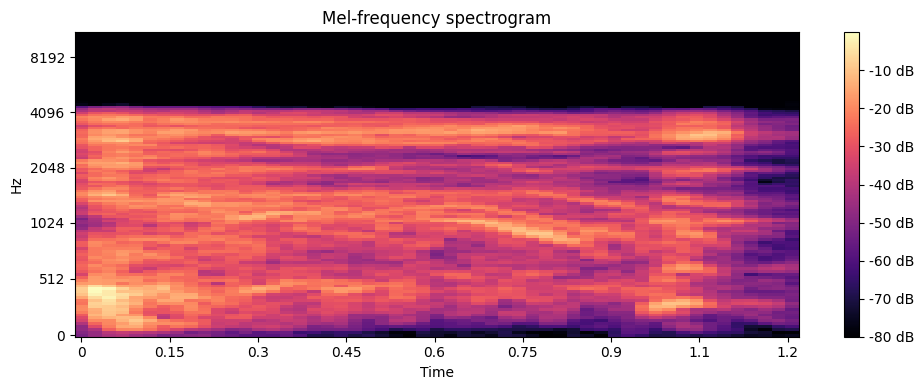

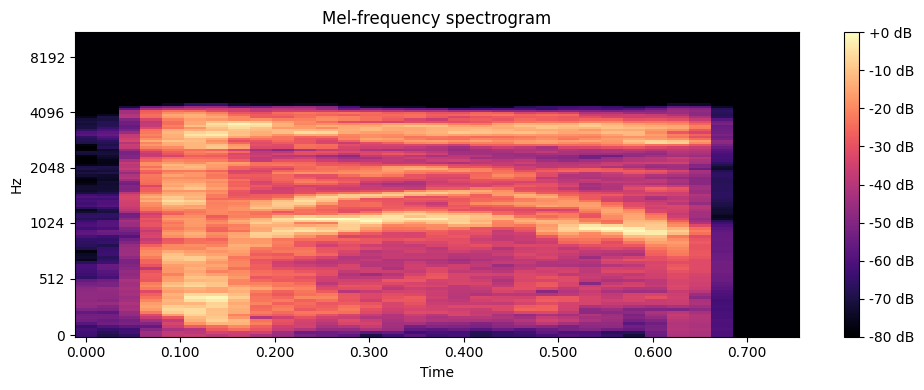

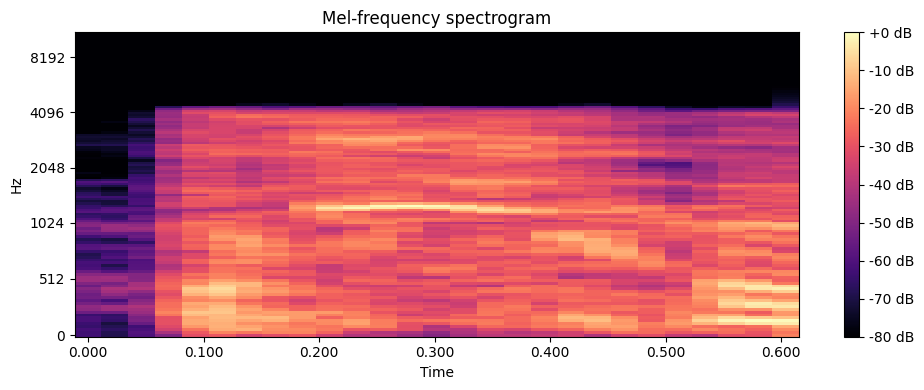

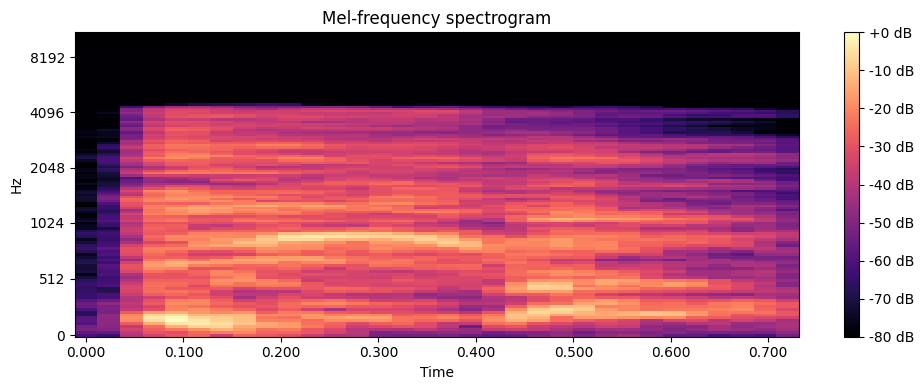

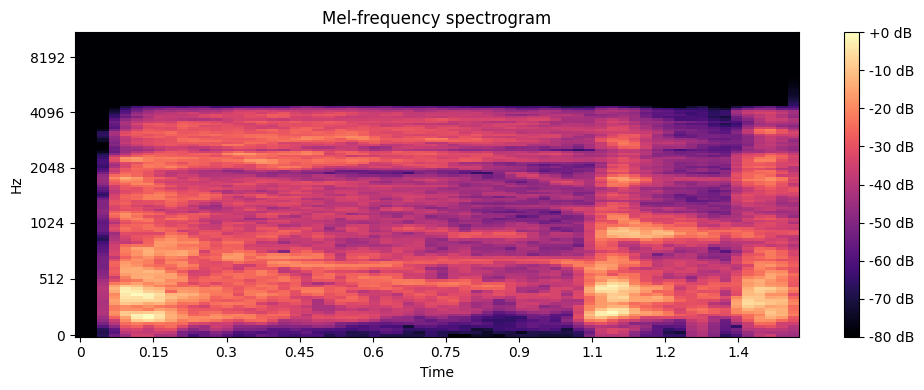

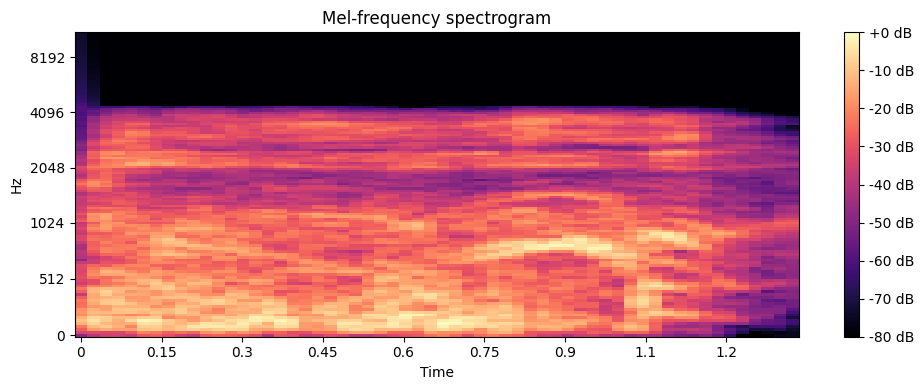

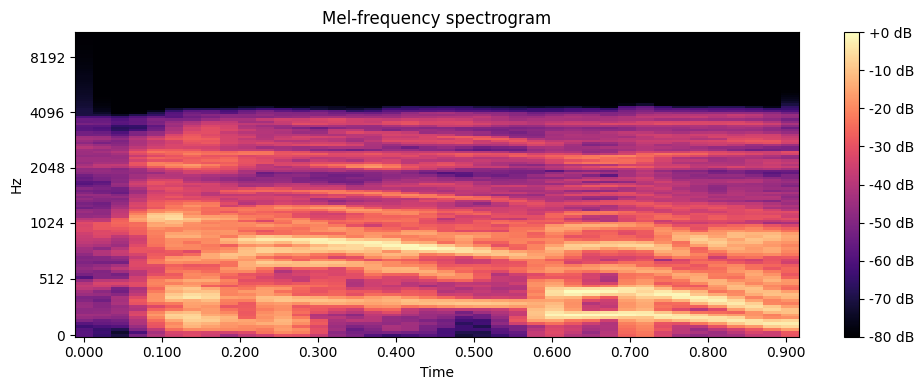

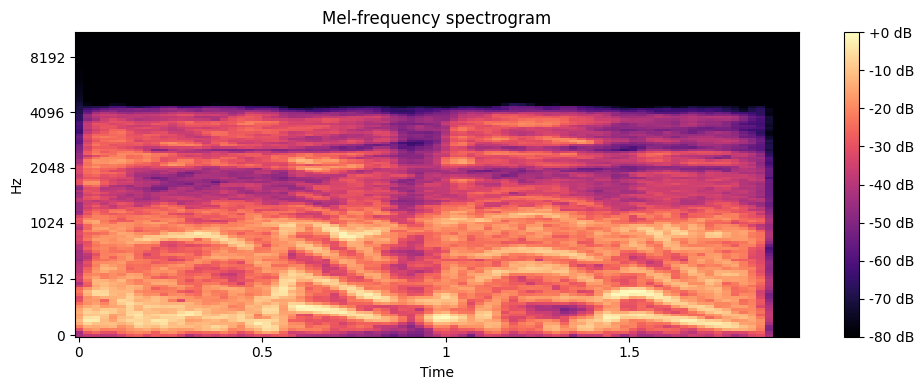

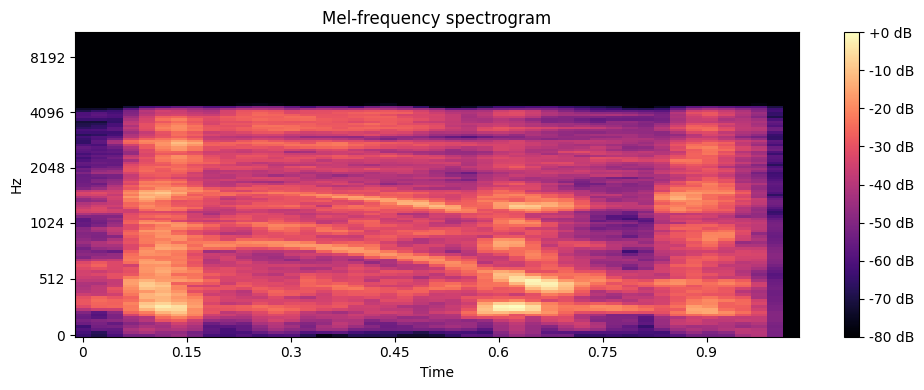

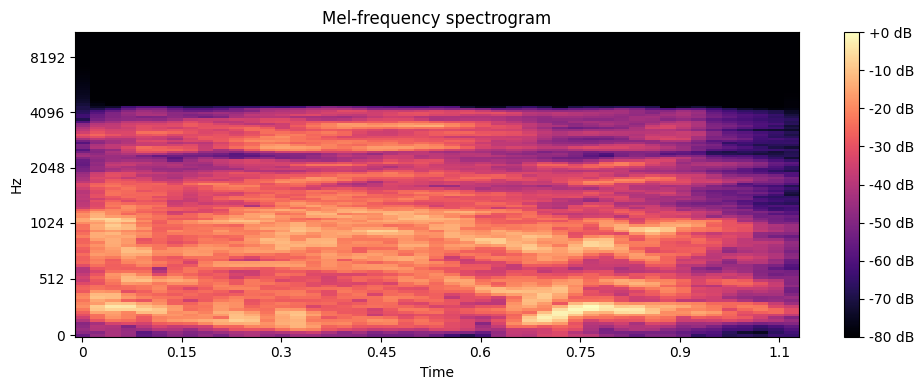

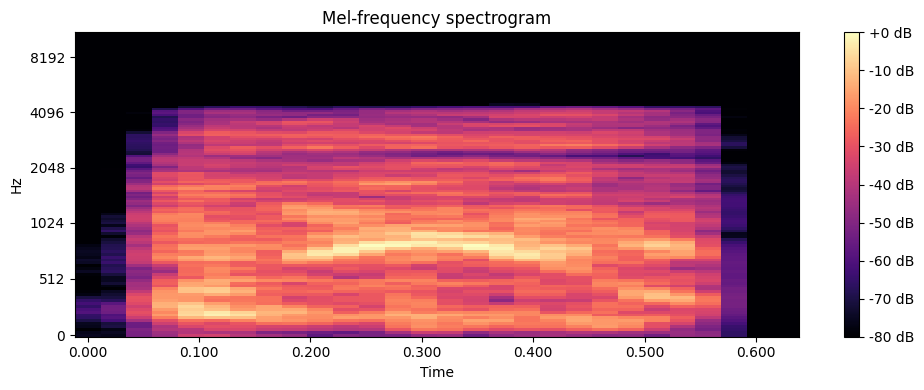

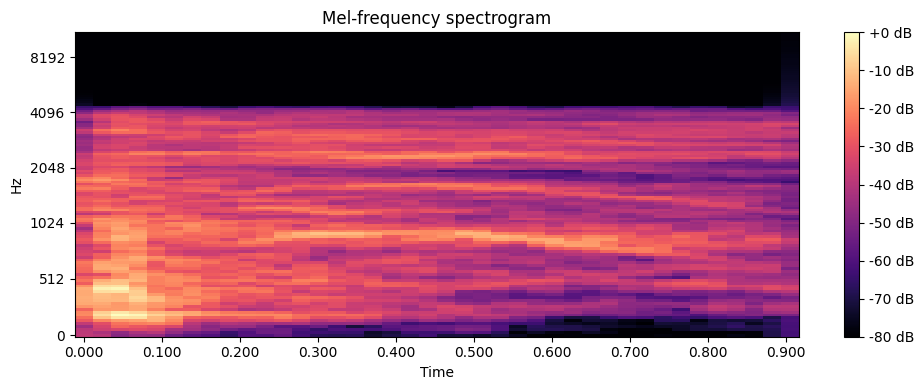

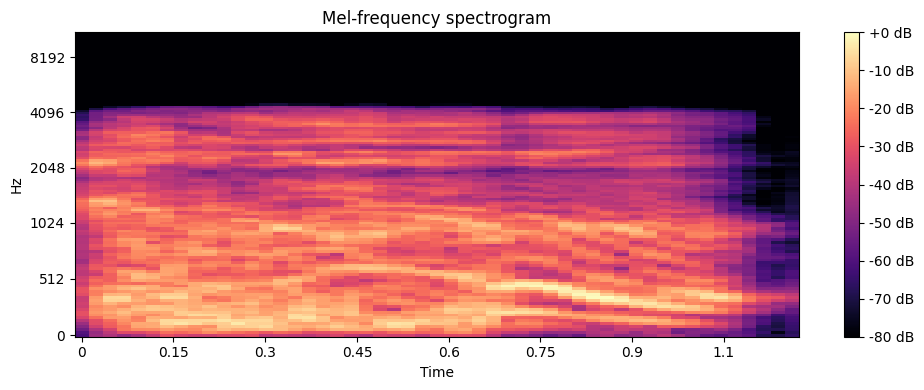

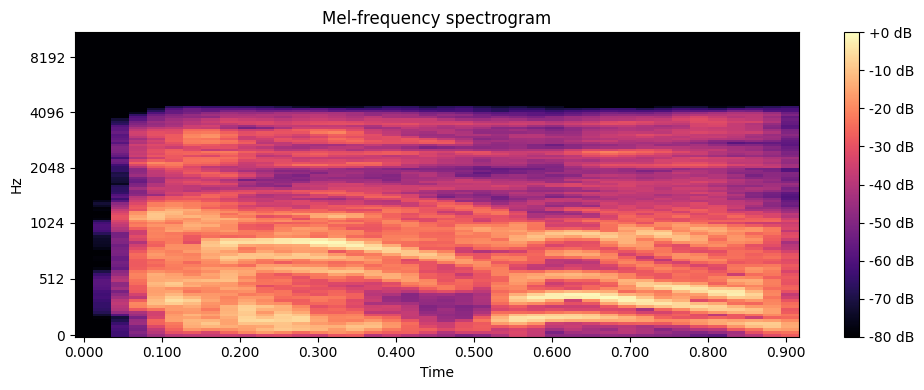

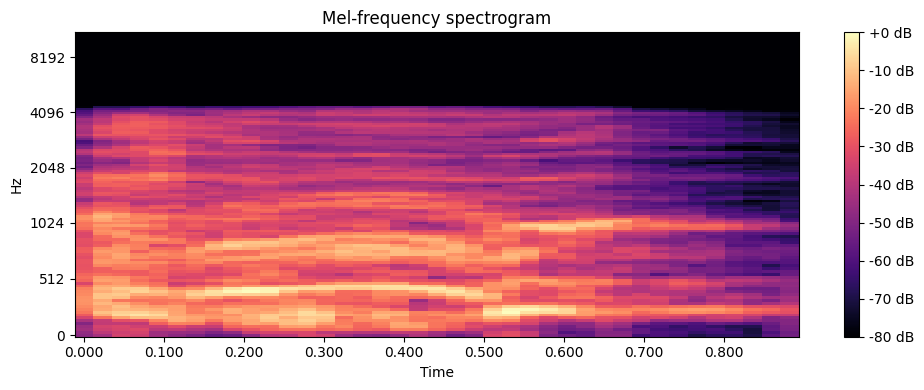

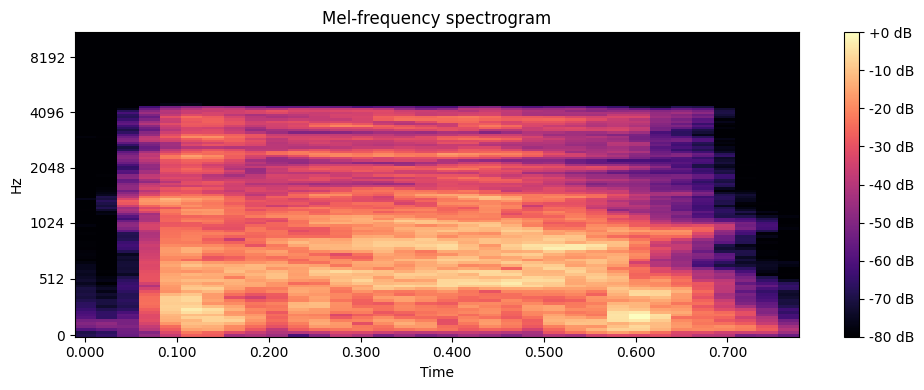

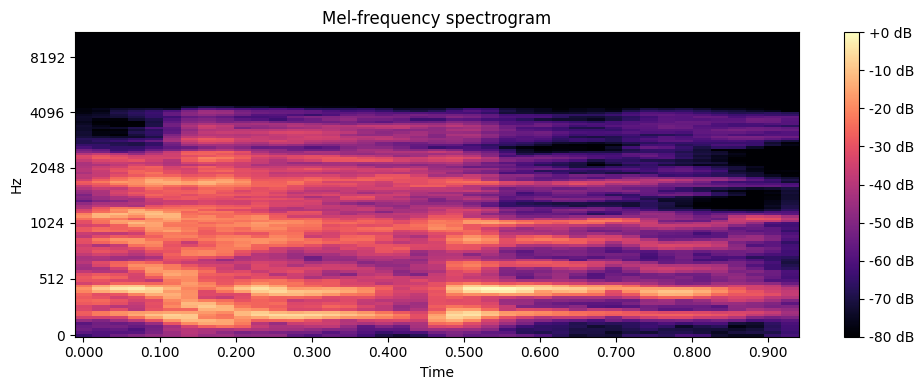

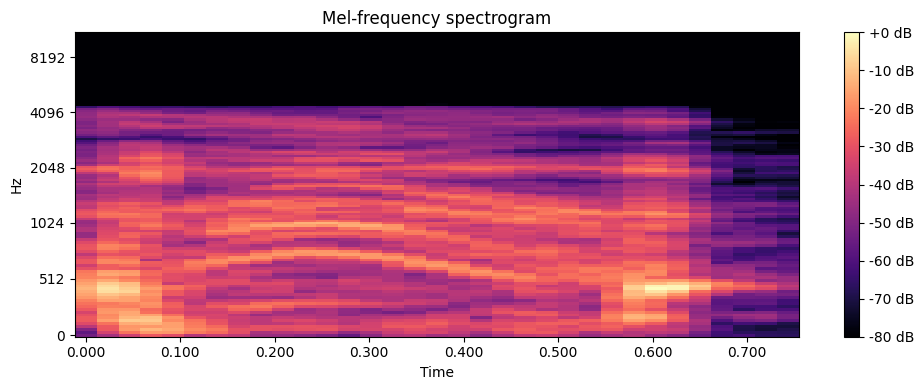

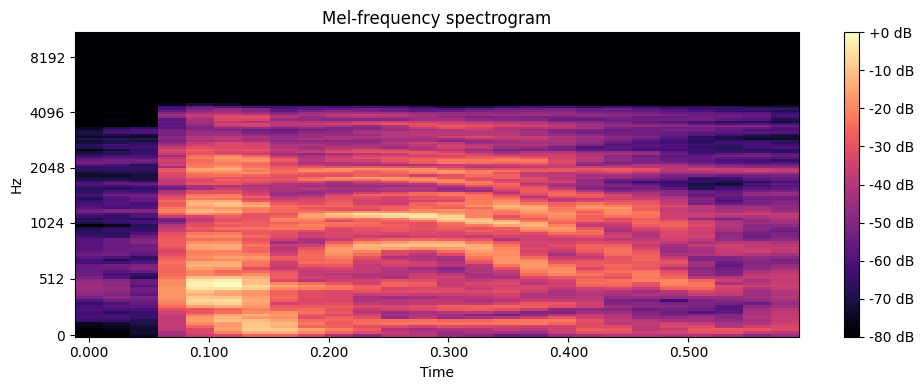

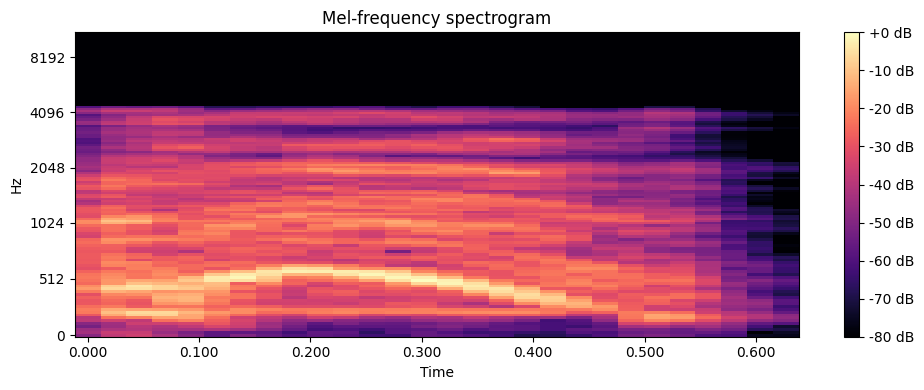

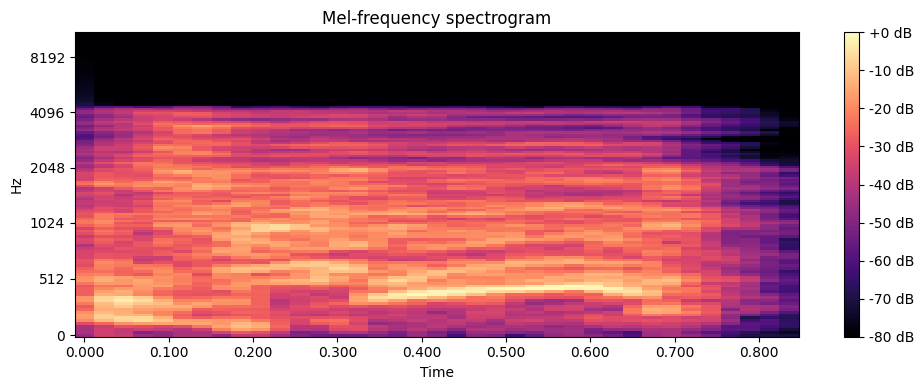

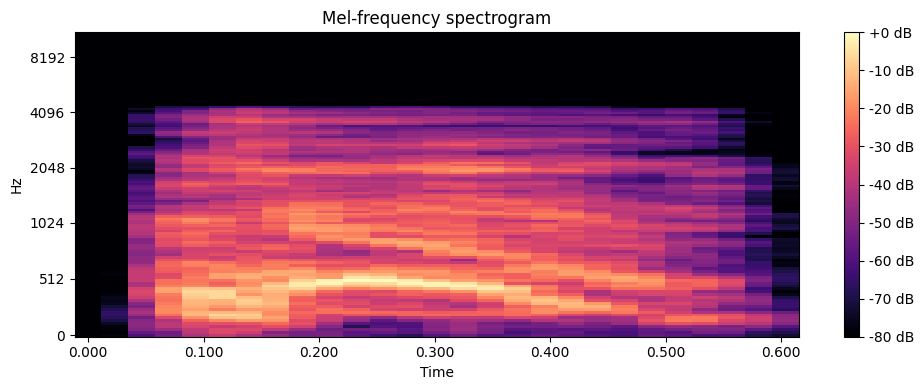

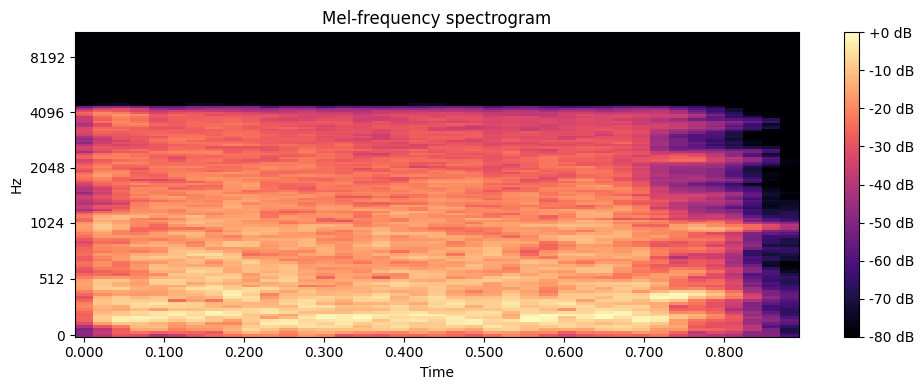

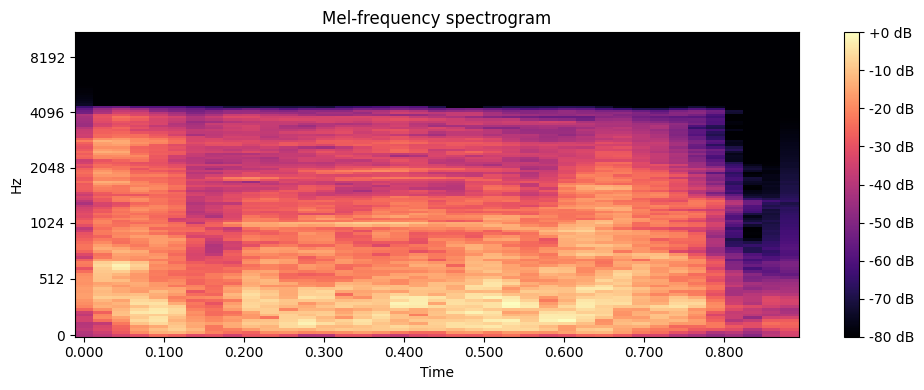

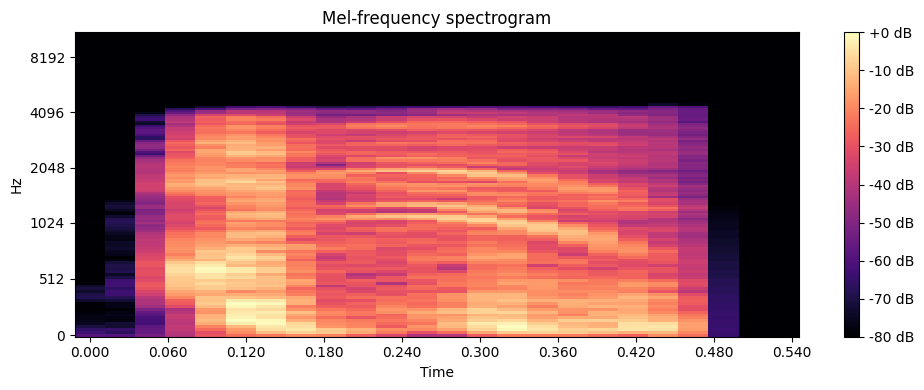

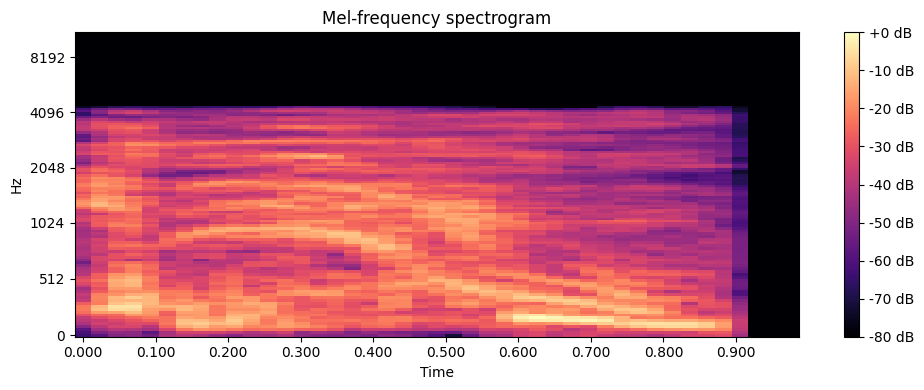

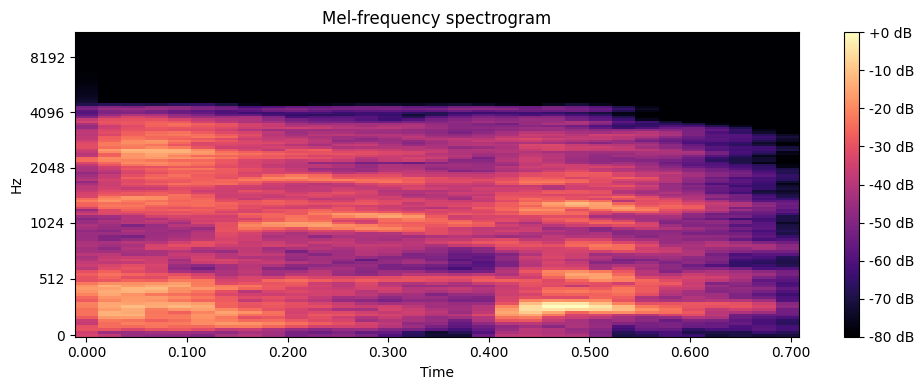

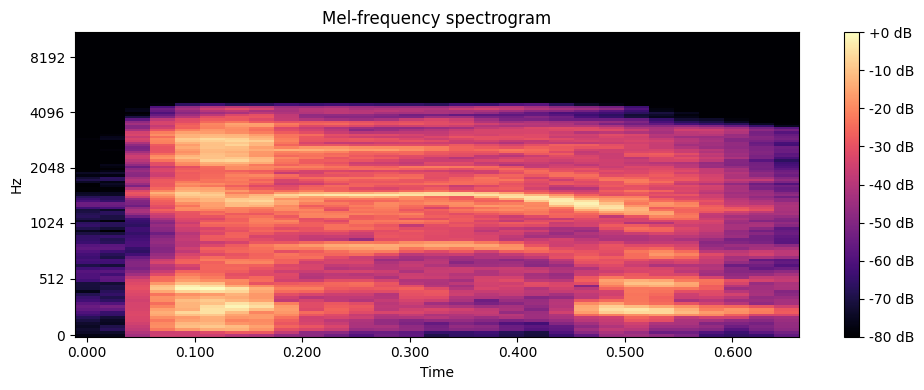

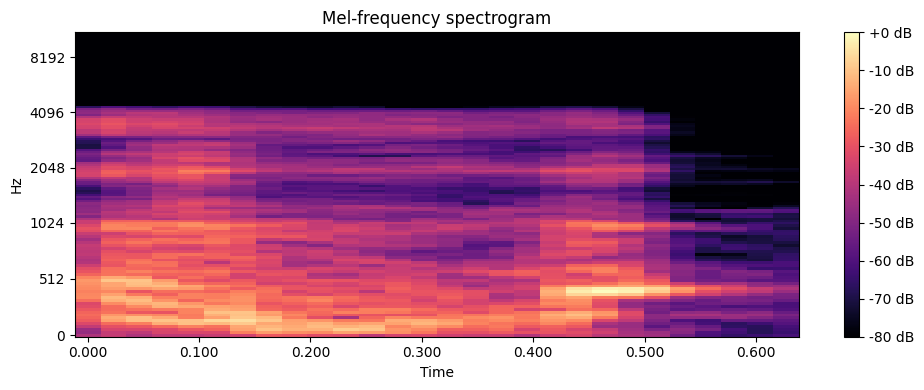

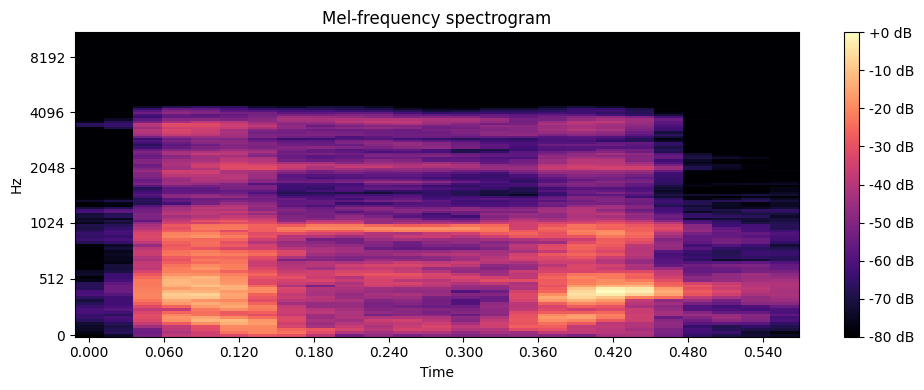

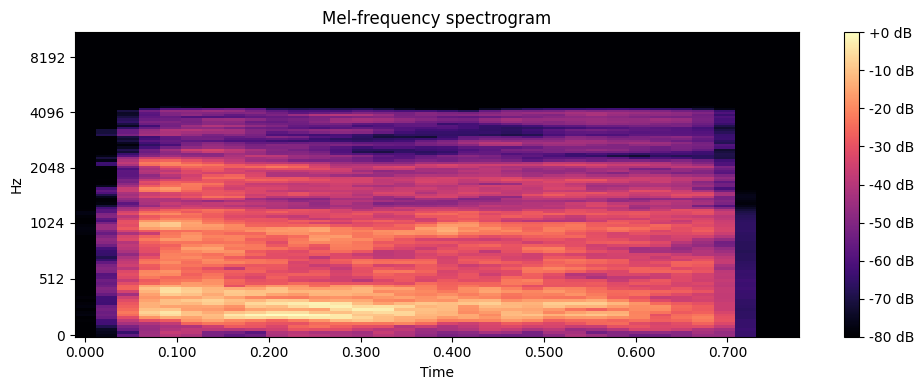

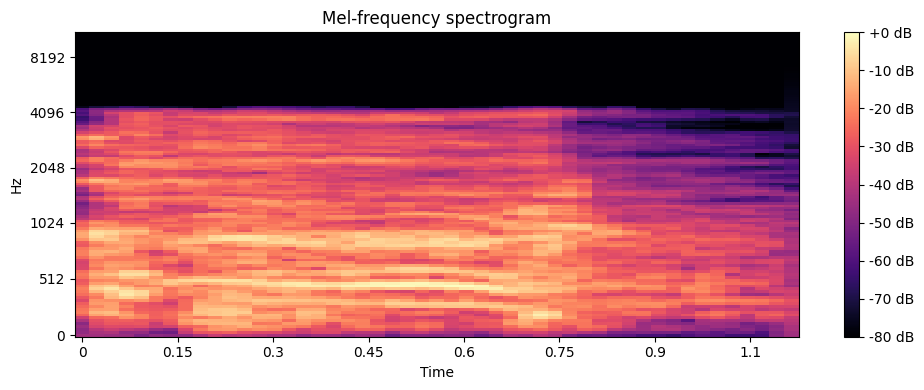

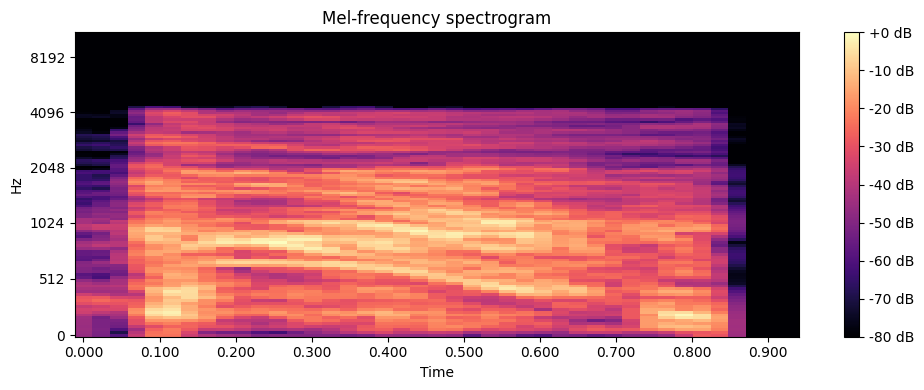

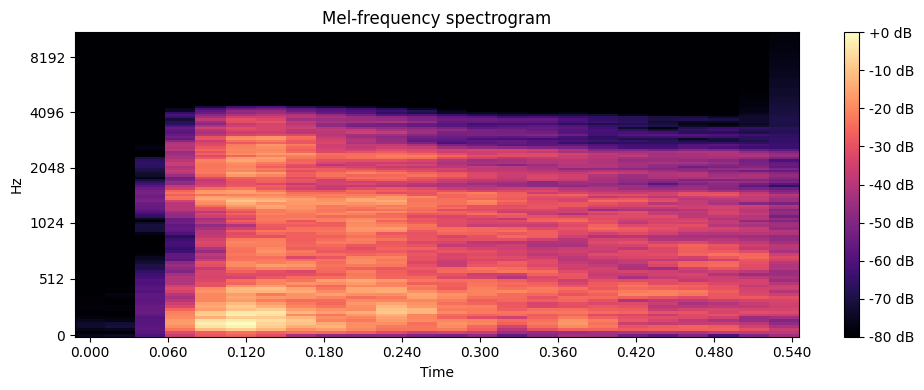

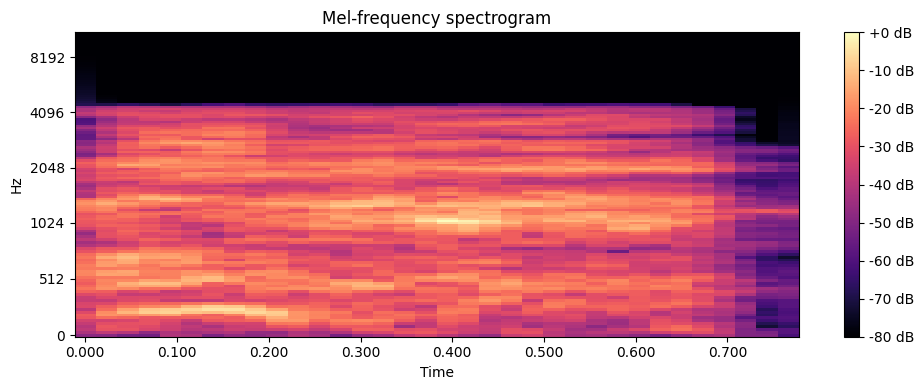

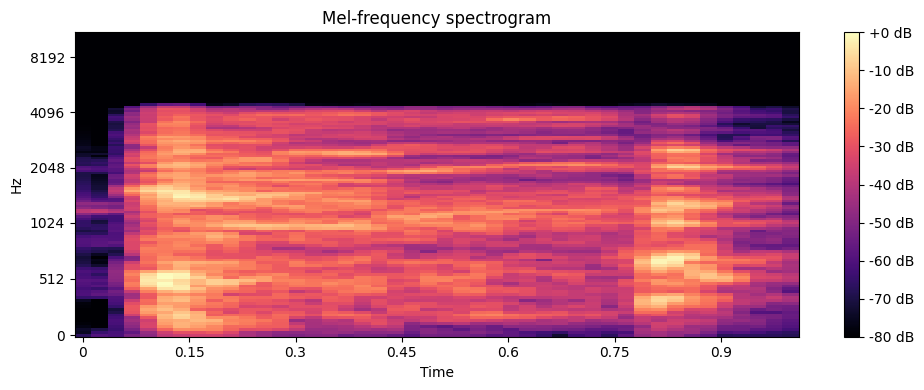

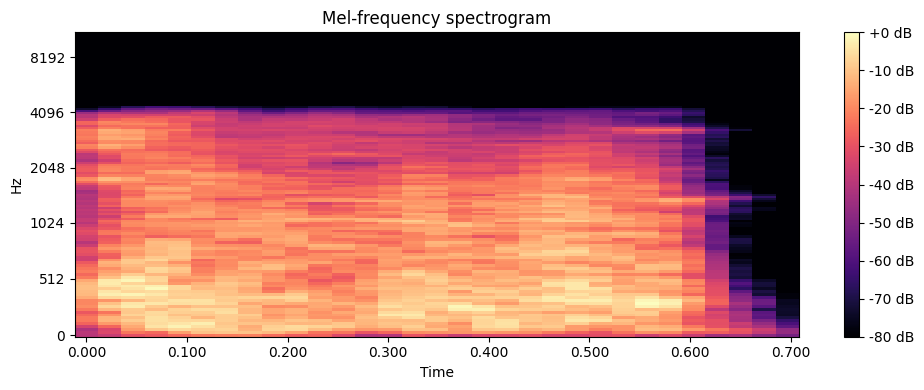

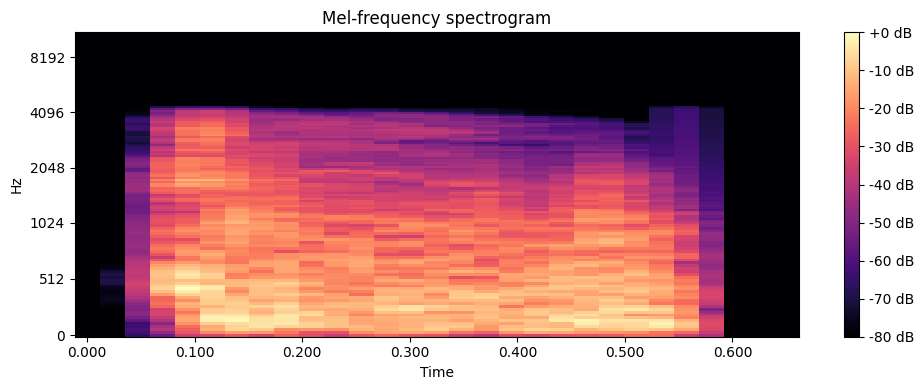

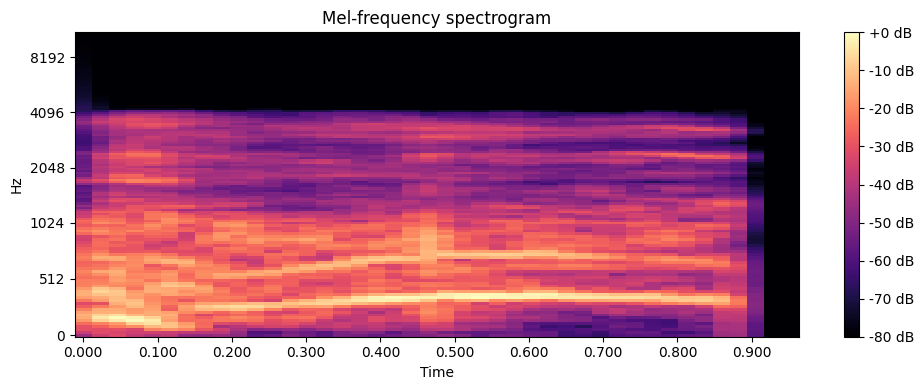

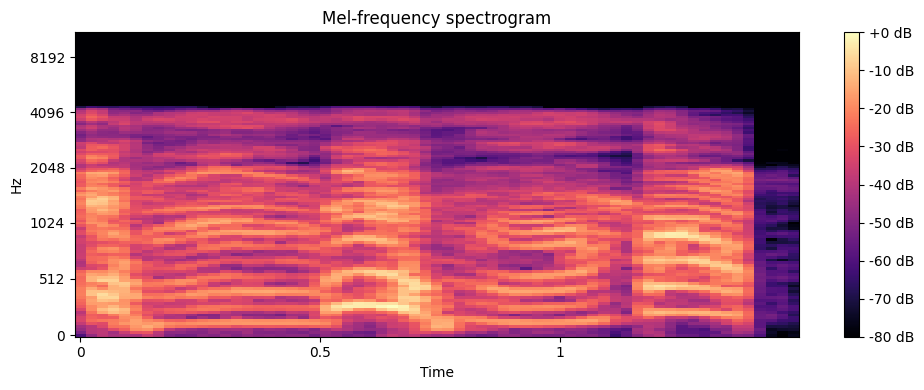

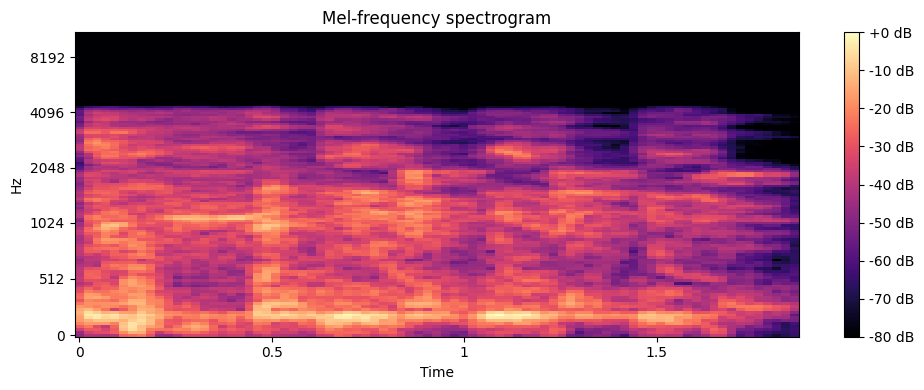

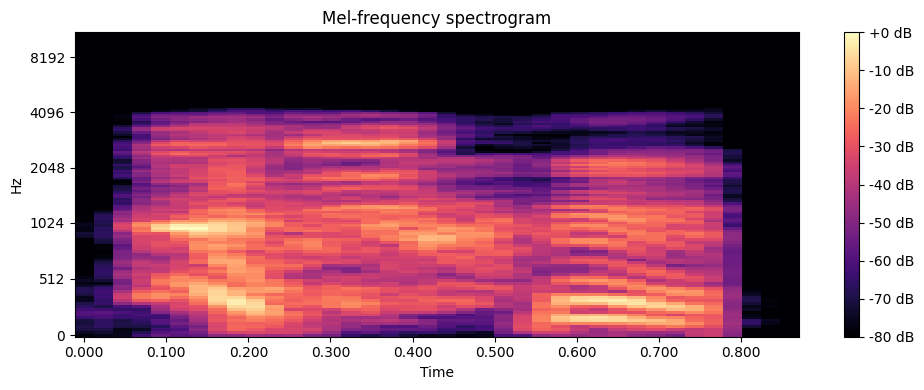

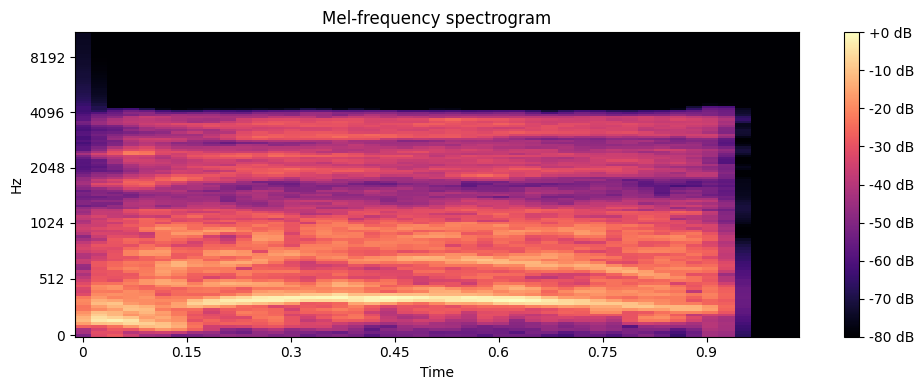

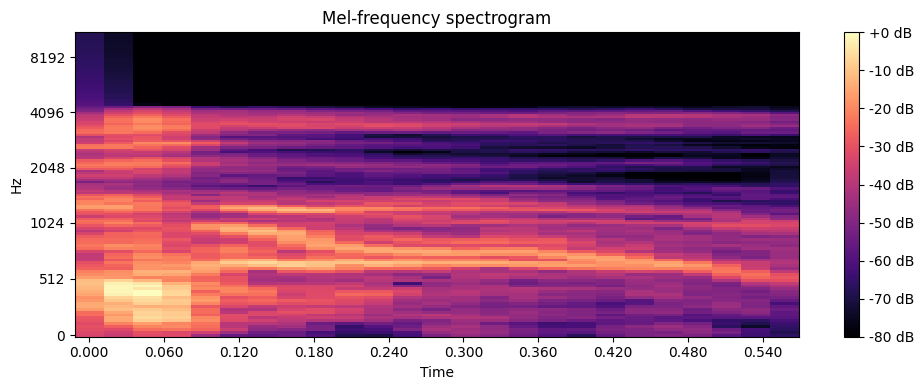

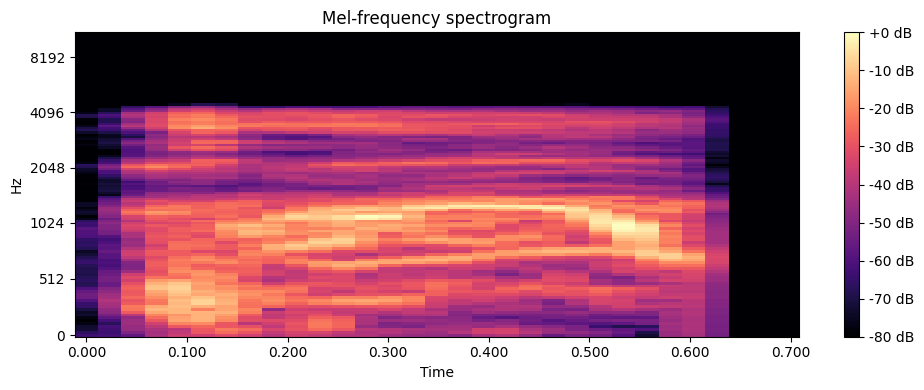

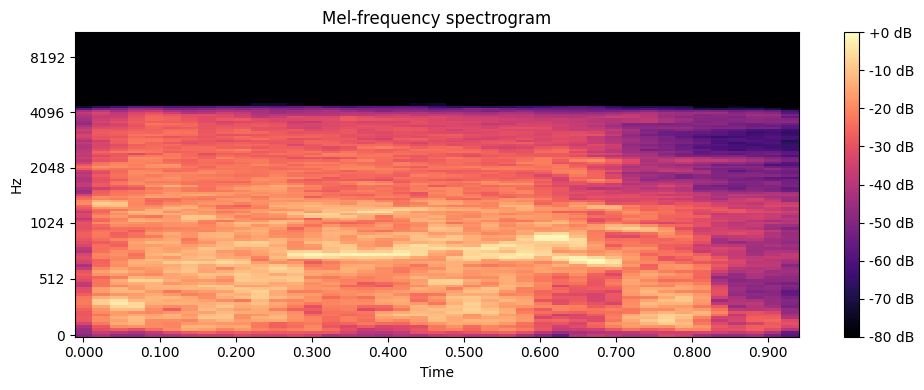

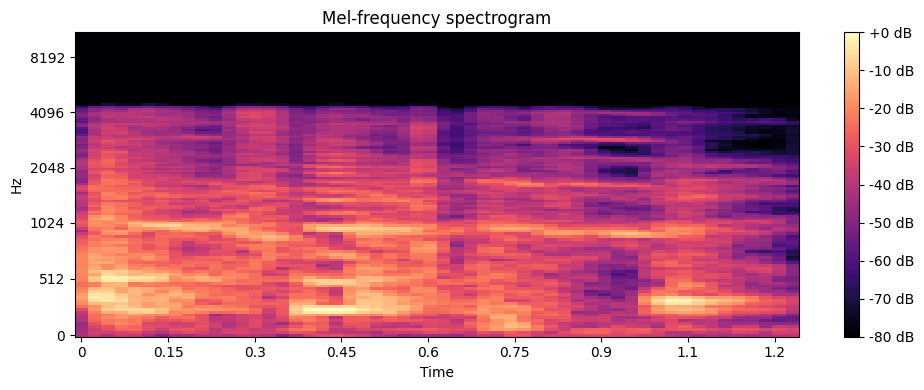

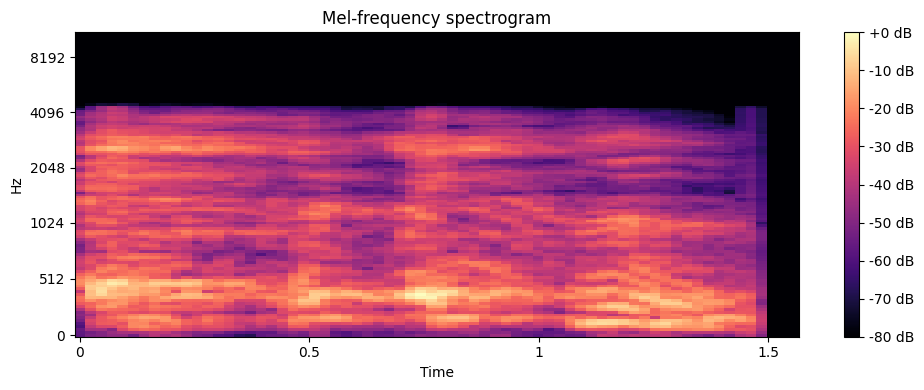

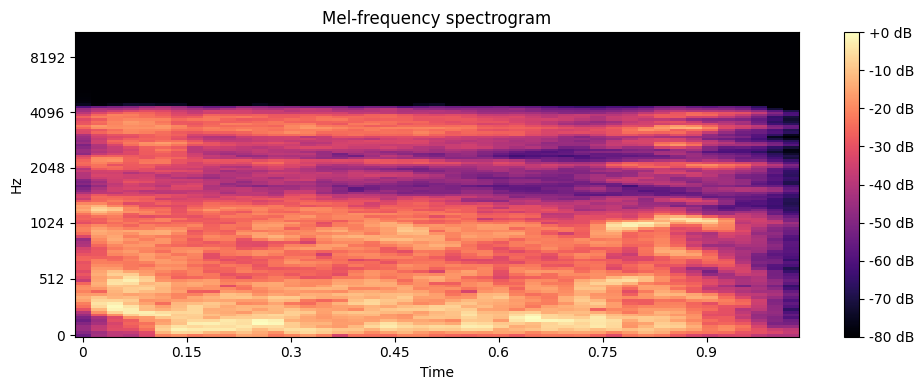

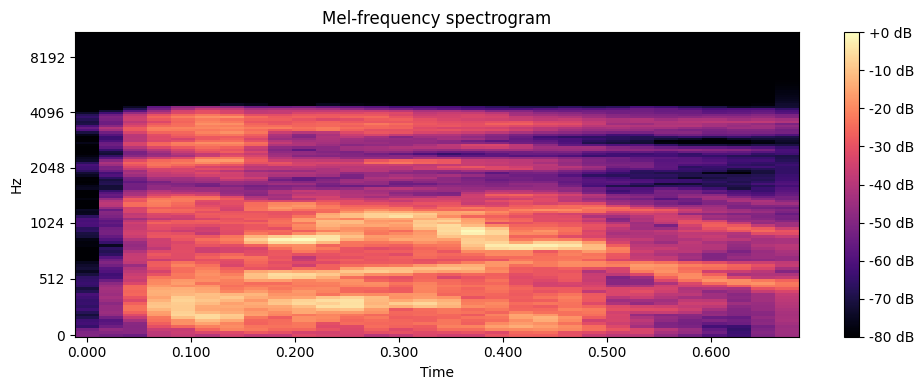

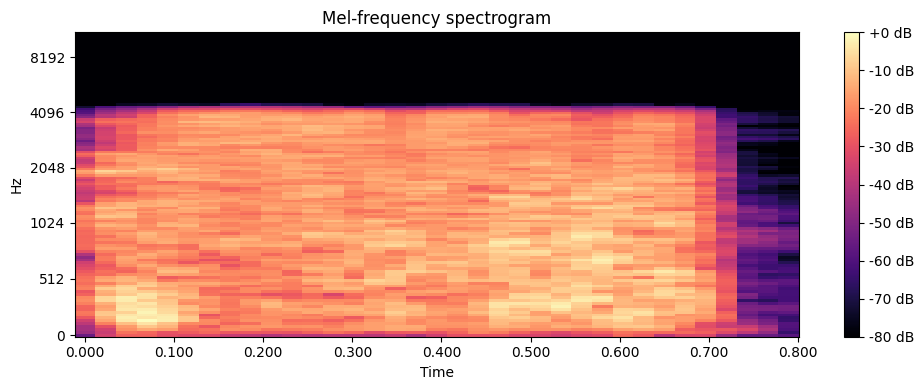

KeyboardInterrupt: 

In [67]:
import librosa.display
import matplotlib.pyplot as plt

for i in range(len(cough_data['obstructive'])):
    mel_spectrogram = cough_data['obstructive'][i]

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()


In [73]:
print(cough_data['healthy'][0])

[[-45.959995 -44.69272  -46.826576 ... -80.       -80.       -80.      ]
 [-48.458435 -40.38865  -41.458942 ... -80.       -80.       -80.      ]
 [-44.06295  -36.62664  -34.88357  ... -80.       -80.       -80.      ]
 ...
 [-77.725266 -80.       -80.       ... -80.       -80.       -80.      ]
 [-77.77947  -80.       -80.       ... -80.       -80.       -80.      ]
 [-77.813225 -80.       -80.       ... -80.       -80.       -80.      ]]


In [68]:
import os
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np

# label_to_int = {
#     'covid': 0,
#     'healthy': 1,
#     'lower': 2,
#     'upper': 3,
#     'obstructive': 4
# }

target_shape = (128, 128)
label_folders = ['covid', 'healthy', 'lower', 'upper', 'obstructive']

def resize_spectrogram(spectrogram, target_shape):
    output = np.zeros(target_shape)
    original_shape = spectrogram.shape

    time_frames = min(original_shape[1], target_shape[1])
    output[:, :time_frames] = spectrogram[:, :time_frames]

    return output

new_cough_data = {}
for i in label_folders:
    new_cough_data[i] = []

for label, spectrograms in cough_data.items():
    for spectrogram in spectrograms:
        resized_spectrogram = resize_spectrogram(spectrogram, target_shape)
        new_cough_data[label].append(resized_spectrogram)
        # y.append(label_to_int[label])

base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)

def get_features(img):
    x = img
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    flatten = model.predict(x)
    return list(flatten[0])

X = []
y = []


for cplot in new_cough_data['covid']:
    X.append(get_features(cplot))
    y.append(0)

for cplot in new_cough_data['upper']:
    X.append(get_features(cplot))
    y.append(1)

for cplot in new_cough_data['lower']:
    X.append(get_features(cplot))
    y.append(2)

for cplot in new_cough_data['healthy']:
    X.append(get_features(cplot))
    y.append(3)

for cplot in new_cough_data['obstructive']:
    X.append(get_features(cplot))
    y.append(4)




ValueError: could not broadcast input array from shape (128,36) into shape (224,36)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

# get the accuracy
print (accuracy_score(y_test, predicted))

# X = np.array(X)
# y = np.array(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_test shape: {y_test.shape}")

In [52]:
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input

def mel_to_image(spectrogram):
  img = np.stack((spectrogram,) * 3, axis=-1)
  img = preprocess_input(img)
  return img

X_train_images = np.array([mel_to_image(spec) for spec in X_train])

X_test_images = np.array([mel_to_image(spec) for spec in X_test])

In [53]:
print(X_train_images.shape)
print(X_test_images.shape)
print(y_train.shape)
print(y_test.shape)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)


(3810, 128, 128, 3)
(673, 128, 128, 3)
(3810,)
(673,)


In [46]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications import vgg16
#from keras.utils import to_categorical #Removed import as this is no longer needed


model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in model.layers:
  layer.trainable = False

flatten = Flatten()
new_layer2 = Dense(5, activation='softmax', name='my_dense_2')

inp2 = model.input
out2 = new_layer2(flatten(model.output))

model2 = Model(inp2, out2)
model2.summary(line_length=150)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                                     ┃ Output Shape                                  
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_9 (InputLayer)                                       │ (None, 128, 128, 3)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block1_conv1 (Conv2D)                                            │ (None, 128, 128, 64)                          
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block1_conv2 (Conv2D)                                            │ (None, 128, 128, 64)                          
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block1_pool (MaxPooling2D)                                       │ (None, 64, 64, 64)                            
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block2_conv1 (Conv2D)                                            │ (None, 64, 64, 128)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block2_conv2 (Conv2D)                                            │ (None, 64, 64, 128)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block2_pool (MaxPooling2D)                                       │ (None, 32, 32, 128)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block3_conv1 (Conv2D)                                            │ (None, 32, 32, 256)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block3_conv2 (Conv2D)                                            │ (None, 32, 32, 256)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block3_conv3 (Conv2D)                                            │ (None, 32, 32, 256)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block3_pool (MaxPooling2D)                                       │ (None, 16, 16, 256)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block4_conv1 (Conv2D)                                            │ (None, 16, 16, 512)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block4_conv2 (Conv2D)                                            │ (None, 16, 16, 512)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block4_conv3 (Conv2D)                                            │ (None, 16, 16, 512)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block4_pool (MaxPooling2D)                                       │ (None, 8, 8, 512)                             
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ block5_conv1 (Conv2D)                                            │ (None, 8, 8, 512)                             
├───────────────────────────────────────────────────────

 Total params: 14,755,653 (56.29 MB)

 Trainable params: 40,965 (160.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [48]:
from keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Fit the model
history = model2.fit(
    X_train_images,
    y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    callbacks=[lr_scheduler]
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7074 - loss: 0.7487 - val_accuracy: 0.3241 - val_loss: 2.2268 - learning_rate: 1.2500e-04
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7058 - loss: 0.7579 - val_accuracy: 0.3530 - val_loss: 2.3209 - learning_rate: 1.2500e-04
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7168 - loss: 0.7356 - val_accuracy: 0.3635 - val_loss: 2.1428 - learning_rate: 1.2500e-04
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7256 - loss: 0.7320 - val_accuracy: 0.3491 - val_loss: 2.1654 - learning_rate: 1.2500e-04
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7211 - loss: 0.7235 - val_accuracy: 0.3425 - val_loss: 2.2653 - learning_rate: 1.2500e-04
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7472 - loss: 0.6732 - val_accuracy: 0.3491 - val_loss: 2.1762 - learning_rate: 6.2500e-05
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc